In [160]:
import os
import numpy as np
import pandas as pd
import pymc3 as pm
import tensorflow as tf
import theano.tensor as T
import matplotlib.pyplot as plt
import jax.numpy as jnp

from tensorflow.keras.models import load_model
from pymc3 import sampling_jax
from jax import nn, jit

import arviz as az
print('tensorflow ==', tf.__version__)

%matplotlib inline

tensorflow == 2.3.2


## Emulator

In [3]:
path = 'models/model_1'
model = load_model(path)

In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 6)                 13        
_________________________________________________________________
dense (Dense)                (None, 128)               896       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               1

In [6]:
weights = model.get_weights()

In [56]:
input_offset = model.layers[0].mean.numpy()
input_scale = np.sqrt(model.layers[0].variance.numpy())

In [57]:
output_offset = np.array(model.layers[-1].offset)
output_scale = np.array(model.layers[-1].scale)

In [112]:
w = weights[3:-1:2]
b = weights[4::2]

In [118]:
inputs = np.array([[2.0, 2.0], [1.0, 1.0], [0.0, 0.0], [1.7, 1.7], [5., 5.], [3., 3.]]).T

In [121]:
def emulate(inputs):
    inputs = (input_offset - inputs) / input_scale
    for wi, bi in zip(w[:-1], b[-1]):
        inputs = T.nnet.elu(T.dot(inputs, wi) + bi)
    outputs = T.dot(inputs, w[-1]) + b[-1]
    outputs = output_offset + outputs * output_scale
    return outputs

## Data

In [147]:
bulk = pd.read_csv('data/inputs/bulk_inputs.csv')
bulk.head()

,KIC,R,err_R,M,err_M,Age,err_Age,alpha,err_alpha,Teff,err_Teff,[M/H],err_[M/H],L,err_L
0,3427720,1.113,0.007,1.102,0.017,2.296,0.151,1.69,0.07,6045,77,-0.06,0.1,1.590,0.066
1,3656476,1.327,0.013,1.105,0.030,8.741,0.527,1.75,0.07,5668,77,0.25,0.1,1.779,0.077
2,3735871,1.107,0.009,1.132,0.024,1.836,0.231,1.73,0.09,6107,77,-0.04,0.1,1.638,0.073
3,4914923,1.383,0.010,1.134,0.022,6.410,0.437,1.66,0.06,5805,77,0.08,0.1,2.138,0.098
4,5184732,1.369,0.009,1.282,0.024,4.832,0.308,1.65,0.08,5846,77,0.36,0.1,1.947,0.061


In [148]:
hall = pd.read_csv('data/hall2021/table1.csv', index_col=0)
hall.head()

,KIC,Teff,eTeff,age,loage,upage,modmass,lomodmass,upmodmass,feh,...,u_nus*,i,l_i,u_i,P,l_P,u_P,flag,hrclass,source
0,1435467,6326,77,3.0164,0.3513,0.4951,1.3189,0.0513,0.0304,0.01,...,0.097947,63.426473,6.630832,10.191850,6.541180,0.620728,0.757775,0,H,L
1,2837475,6614,77,1.6270,0.1757,0.1118,1.4291,0.0209,0.0190,0.01,...,0.075408,70.745188,4.373721,6.031740,3.499114,0.154079,0.172064,0,H,L
2,3425851,6343,85,3.3200,0.6400,0.8500,1.1780,0.0490,0.0490,-0.04,...,0.478841,60.891571,22.743612,20.057892,8.082749,2.709672,8.637542,0,H,K
3,3427720,6045,77,2.2339,0.2396,0.2396,1.1080,0.0095,0.0209,-0.06,...,0.056955,56.407964,23.391922,22.854263,31.590512,11.821919,10.236450,0,MS,L
4,3456181,6384,77,2.0901,0.1278,0.1278,1.4975,0.0190,0.0304,-0.15,...,0.079464,58.206608,17.723228,20.416392,10.699926,2.790842,2.006340,0,H,L


In [149]:
hall['KIC'] = hall['KIC'].astype(str)

In [150]:
period_cols = ['KIC', 'P', 'l_P', 'u_P', 'flag', 'hrclass']

hall[period_cols].head()

,KIC,P,l_P,u_P,flag,hrclass
0,1435467,6.541180,0.620728,0.757775,0,H
1,2837475,3.499114,0.154079,0.172064,0,H
2,3425851,8.082749,2.709672,8.637542,0,H
3,3427720,31.590512,11.821919,10.236450,0,MS
4,3456181,10.699926,2.790842,2.006340,0,H


In [151]:
df = bulk.merge(hall[period_cols], on='KIC')

In [193]:
data = df.loc[(df['M'] + 2*df['err_M'] < 1.2) & (df['alpha'] + 2*df['err_alpha'] < 2.0)]
data.head()

,KIC,R,err_R,M,err_M,Age,err_Age,alpha,err_alpha,Teff,err_Teff,[M/H],err_[M/H],L,err_L,P,l_P,u_P,flag,hrclass
0,3427720,1.113,0.007,1.102,0.017,2.296,0.151,1.69,0.07,6045,77,-0.06,0.1,1.590,0.066,31.590512,11.821919,10.236450,0,MS
1,3656476,1.327,0.013,1.105,0.030,8.741,0.527,1.75,0.07,5668,77,0.25,0.1,1.779,0.077,48.040844,12.682362,8.116435,0,MS
2,3735871,1.107,0.009,1.132,0.024,1.836,0.231,1.73,0.09,6107,77,-0.04,0.1,1.638,0.073,15.810470,2.465683,1.821666,0,MS
3,4914923,1.383,0.010,1.134,0.022,6.410,0.437,1.66,0.06,5805,77,0.08,0.1,2.138,0.098,21.393839,3.536735,5.394345,0,MS
5,6116048,1.240,0.009,1.062,0.020,5.753,0.338,1.70,0.09,6033,77,-0.23,0.1,1.997,0.072,17.901072,1.185210,0.849631,0,MS


In [194]:
len(data)

15

## Model

In [196]:
n_stars = len(data)

with pm.Model() as model:
    eep = pm.Uniform('eep', 1.0, 3.0, shape=n_stars)
    mass = pm.Normal('mass', data['M'], data['err_M'], shape=n_stars)
    feh = pm.Normal('feh', data['[M/H]'] - 0.05, data['err_[M/H]'], shape=n_stars)
    mlt = pm.Normal('mlt', data['alpha'], data['err_alpha'], shape=n_stars)
    fk = pm.Normal('fk', 5.0, 0.1, shape=n_stars)
    rocrit = pm.Normal('rocrit', 3.0, 0.1, shape=n_stars)
    
    inputs = T.stack([eep, mass, feh, mlt, fk, rocrit]).T
    outputs = emulate(inputs)
    
    logp = pm.Normal.dist(data['Age'], 2*data['err_Age']).logp(10**outputs[:, 0])
    age = pm.Potential('age', logp)
#     age = pm.Deterministic('age', 10**outputs[:, 0])
    teff = pm.Deterministic('teff', 10**outputs[:, 1])
    radius = pm.Deterministic('radius', 10**outputs[:, 2])
    fehs = pm.Deterministic('fehs', outputs[:, 3])
    prot = pm.Deterministic('prot', 10**outputs[:, 4])
    
#     prior_age = pm.Normal('prior_age', age, data['err_Age'], observed=data['Age'])

In [197]:
with model:
    trace = pm.sample(init='adapt_diag')

/home/ADF/ajl573/.virtualenvs/tensorflow/lib/python3.6/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
INFO:pymc3:Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rocrit, fk, mlt, feh, mass, eep]
INFO:pymc3:NUTS: [rocrit, fk, mlt, feh, mass, eep]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 107 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 107 seconds.
There were 285 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 285 divergences after tuning. Increase `target_accept` or reparameterize.
There were 410 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 410 divergences after tuning. Increase `target_accept` or reparameterize.
There were 443 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 443 divergences after tuning. Increase `target_accept` or reparameterize.
There were 450 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 450 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some par

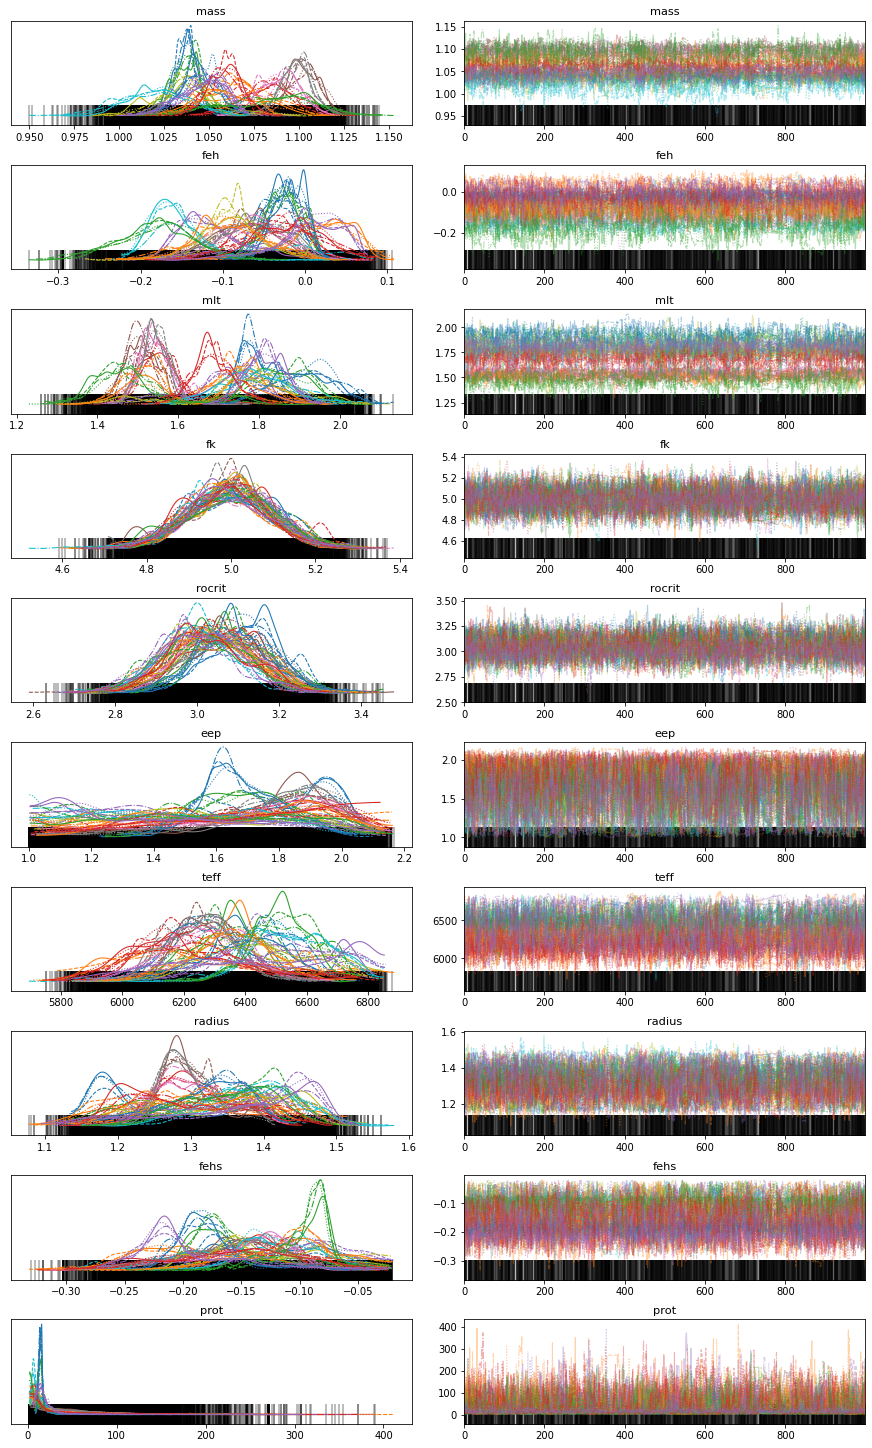

In [198]:
with model:
    az.plot_trace(trace)

In [166]:
with model:
    summary = az.summary(trace, var_names='age')

In [169]:
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
age[0],2369809.645,1.944435e+07,5.277,7738188.134,427718.667,302485.464,2067.0,2067.0,3861.0,2214.0,1.0
age[1],6826.562,3.358680e+02,6261.662,7497.039,6.497,4.621,2672.0,2642.0,2720.0,2213.0,1.0
age[2],1.124,2.390000e-01,0.664,1.412,0.004,0.003,4526.0,4526.0,5511.0,2434.0,1.0
age[3],0.532,3.010000e-01,0.041,0.883,0.005,0.003,4077.0,4077.0,3392.0,2238.0,1.0
age[4],284.101,3.451760e+02,4.787,1001.455,6.054,4.281,3251.0,3251.0,2837.0,2747.0,1.0
